# Surrogate models in Bayesian optimization
Common choices for probabilistic surrogate models are Gaussian processes and tree-based models (Random Forests, Extra Trees, Gradient-Boosted Trees) with uncertainty estimate.
While the predictive mean of these models is rather similar, the predictive variance can be rather different between these models, as shown in the following for the case of 5 data points sampled from the 1D Forrester function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
import GPyOpt
import skopt

In [2]:
np.random.seed(1337)
f_true = GPyOpt.objective_examples.experiments1d.forrester()
f_noisy = GPyOpt.objective_examples.experiments1d.forrester(sd=0.5)

X_data = np.array([0.1, 0.5, 0.63, 0.7, 0.92]).reshape(-1, 1)
Y_data = f_noisy.f(X_data)

x = np.linspace(0, 1, 201)
X = x.reshape(-1, 1)

In [3]:
def plot_posterior(x, μ, σ, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(X_data, Y_data, "ko", label="data")
    ax.plot(x, μ, label="mean")
    ax.fill_between(x, (μ - σ), (μ + σ), alpha=.2, label="68% interval")
    ax.set(xlabel="$x$", ylabel="f(x)", xlim=(0, 1))
    ax.legend(loc="upper left")

## Gaussian Process
The following uses a Matern 5/2 kernel. For other Matern kernels (Exponential, 3/2, RBF) posterior samples differ a lot, whereas their poster mean and variance is quite similar. 

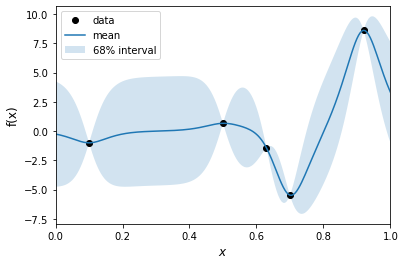

In [4]:
modelGP = GPy.models.GPRegression(X_data, Y_data, kernel=GPy.kern.Matern52(1))
modelGP.optimize_restarts(10, verbose=0)
μGP, varGP = modelGP.predict(X)
μGP = μGP[:, 0]
σGP = varGP[:, 0] ** 0.5
plot_posterior(x, μGP, σGP)

## Random Forest
Random forests are composed of an ensemble of decision trees, each one fit to a different random draw (with replacement) of the training data. The ensemble average is taken as the prediction, whereas the ensemble variance may serve as a measure of the uncertainty.

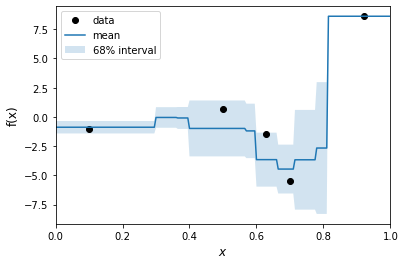

In [5]:
rf = skopt.learning.RandomForestRegressor()
rf.fit(X_data, Y_data)
μRF, σRF = rf.predict(X, return_std=True)
plot_posterior(x, μRF, σRF)

## ExtraTrees
Like Random Forests, ExtraTrees are ensembles of decision trees, trained on random draws of the training data.
The main difference is that in each draw Random forests compute the locally optimal split, whereas ExtraTrees select a random value for the split. This leads to a smoother interpolation, and to a predictive variance that somewhat increases with distance to the nearest data point.

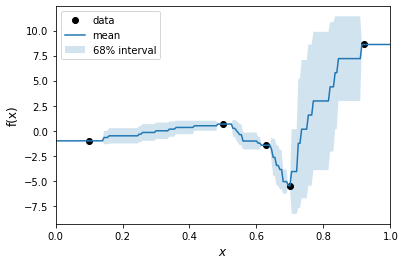

In [6]:
modelET = skopt.learning.ExtraTreesRegressor().fit(X_data, Y_data)
μET, σET = modelET.predict(X, return_std=True)
plot_posterior(x, μET, σET)

## Gradient Boosted Tree
A GBT is boosted ensemble of small fixed size trees.
In the considered example, the GBT interpolates less compared to the other tree-based methods, and the predictive variance is constant with distance to nearest data point. 

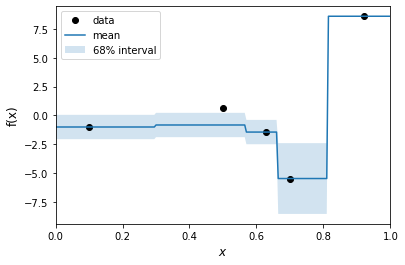

In [7]:
modelGBT = skopt.learning.GradientBoostingQuantileRegressor().fit(X_data, Y_data)
μGBT, σGBT = modelGBT.predict(X, return_std=True)
plot_posterior(x, μGBT, σGBT)

## FUELS  
FUELS (Forests with Uncertainty Estimates for Learning Sequentially) is a random forest model that includes a low capacity model for the uncertainty estimation at each test point.

Reference:
[Ling+ (2017) High-Dimensional Materials and Process Optimization using Data-driven Experimental Design with Well-Calibrated Uncertainty Estimates](https://arxiv.org/abs/1704.07423)